In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Uncertainty

## Types of uncertainty

### Epistemic uncertainty

### Aleatory uncertainty





# Some existing methods for modelling uncertainty

## Monte Carlo Dropout

## Distributional Parameter Learning

## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression


# Uncertainty modelling example

## Function

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$


In [19]:
# Sample data
N = 100

def f(x):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(2 * x)
    return y

x = np.random.uniform(-5, 5, size=N)


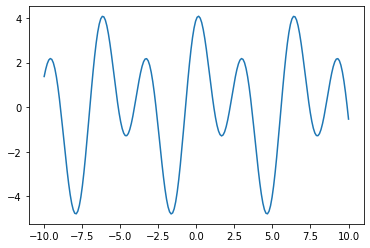

In [20]:
x_plot = np.linspace(-10, 10, num=200)
ax = plt.plot(x_plot, f(x_plot))

In [ ]:
def gaussian_nll(mu_true, mu_pred, sigma_pred):
    return np.log(sigma_pred ** 2) / 2 + ((mu_true - mu_pred) ** 2) / (2 * sigma_pred ** 2)